Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


/usr/lib64/python3.10/site-packages/matplotlib/contour.py:1496: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_1394317/3456304280.py:47: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  chl_data = chl_variable[:]
/usr/lib64/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


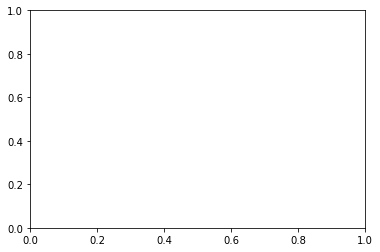

In [16]:
import os
import datetime
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as animation
import matplotlib.colors as colors

# Specify the folder path where netCDF files are located
folder = '/nexsan/people/taylor/NEMURO_GoM/netCDF_GRIIDC/ncfiles/'

# Get the list of netCDF files in the folder
files = os.listdir(folder)

def extract_date(files):
    date_str = files.split('_')[1].split('.')[0]
    return datetime.datetime.strptime(date_str, '%m%d%Y')

sorted_file_names = sorted(files, key=extract_date)

# Select the first 10 files for the animation
files = sorted_file_names[:]

# Define contour levels
contour_levels = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2]

# Define the contour colors using logarithmic scale
contour_colors = colors.LogNorm(vmin=min(contour_levels), vmax=max(contour_levels))

# Create the figure and axes for the plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

# Create a colorbar axis
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position as needed

# Define a function to update the plot for each frame
def update_plot(frame):
    file = files[frame]
    filepath = folder + file
    dataset = nc.Dataset(filepath, 'r')

    # Extract the chlorophyll variable
    chl_variable = dataset.variables['CHL']

    # Get the data and coordinates
    chl_data = chl_variable[:]
    lons = dataset.variables['XC'][:]
    lats = dataset.variables['YC'][:]

    # Clear previous plot
    ax.clear()

    # Plot the contour lines of chlorophyll data
    ax.contour(lons, lats, chl_data[0, :, :], levels=contour_levels, colors='black', linewidths=1, transform=ccrs.PlateCarree())

    # Plot filled contours with modified color scale
    ax.contourf(lons, lats, chl_data[0, :, :], levels=contour_levels, norm=contour_colors, cmap='viridis', transform=ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()

    # Add the date as a suptitle
    date = extract_date(file).strftime('%Y-%m-%d')

    # Set plot title
    ax.set_title(f'Chlorophyll - Date: {date}', fontsize=12, y=0.92)

# Create a dummy contour plot for colorbar mappable
dummy_contour = ax.contourf([0, 0], [0, 0], [[0, 0], [0, 0]], levels=contour_levels, norm=contour_colors, cmap='viridis', transform=ccrs.PlateCarree())
plt.close()  # Close the dummy figure

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=len(files), interval=150)

# Add the colorbar
cbar = plt.colorbar(dummy_contour, cax=cax, label='Chlorophyll (mg m^-3)', orientation='vertical')

# Save the animation as a video file
ani.save('chlorophyll_animation.mp4', writer='ffmpeg')
